### Downloading Data ( Run Once )

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download uw-madison-gi-tract-image-segmentation

 99% 2.28G/2.30G [00:29<00:00, 93.1MB/s]
100% 2.30G/2.30G [00:29<00:00, 82.4MB/s]


In [ ]:
!unzip -h

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [ ]:
! unzip '/content/uw-madison-gi-tract-image-segmentation.zip' -d '/content/drive/MyDrive/Datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0121_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0122_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0123_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0124_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0125_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0126_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0127_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/case77/case77_day20/scans/slice_0128_266_266_1.50_1.50.png  
  inflating: /content/drive/MyDrive/Datasets/train/ca

### Initialize

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
path = '/content/drive/MyDrive/Datasets'

In [ ]:
label = 'stomach'

In [ ]:
batch_size = 32
lr = 0.001

In [ ]:
def getMasks(mask_index, mask_data, category = 'stomach'):
  masks = []
  mask_image= []

  num = 0

  for i in mask_index:
    masks.append(mask_data[i])

  for rle, shape in masks:

    x = list(map(int, rle.split(' ')))

    width,height = shape

    y = np.zeros((width*height))
    
    k = 0
    while k < len(x):
      i = 0
      while i < x[k+1]:
        y[x[k]-1 + i] = 1
        i = i + 1
      k = k + 2

    y = np.reshape(y, (width, height))
    y = cv2.resize(y, (256,256))

    mask_image.append(y)

    num = num + 1
    if num % 1000 == 0: print(num)

  mask_image = np.asarray(mask_image)

  return mask_image

### Preparing Data ( Run Once )

In [ ]:
df = pd.read_csv(path + '/train.csv')

In [ ]:
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [ ]:
df.size

346464

In [ ]:
df = df.dropna()

In [ ]:
df.size

101739

In [ ]:
df.head()

,id,class,segmentation
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...


In [ ]:
label_mapping = {
    'large_bowel': 0,
    'small_bowel': 1,
    'stomach': 2,
}

rlabel_mapping = {
    0: 'large_bowel',
    1: 'small_bowel',
    2: 'stomach',
}

In [ ]:
def getImages(category = 'stomach'):
  images_shape = []
  images = []
  mask_data = []
  mask_index = []

  num = 0

  i = 0

  for index, row in df.iterrows():

    if row[1]!=category: continue

    imgs_path = path + '/train/' + row[0].split('_')[0] + '/' + row[0].split('_')[0] + '_' + row[0].split('_')[1] + '/scans/'

    img = []

    for img_file in os.listdir(imgs_path):

      if img_file.split('_')[1] == row[0].split('_')[3]:

        img = cv2.imread(imgs_path + img_file, cv2.IMREAD_GRAYSCALE)

        images_shape.append(img.shape)
        mask_data.append((row[2],img.shape))
        mask_index.append(i)

        i = i + 1

        img = cv2.resize(img, (256,256))
        img = np.array(img)

        images.append(img)
        break

    num = num + 1
    if num % 1000 == 0: print(num)

  images = np.asarray(images)

  return (images, mask_data, mask_index)

In [ ]:
(images, mask_data, mask_index) = getImages(category = label)

KeyboardInterrupt: ignored

In [ ]:
plt.imshow(images[4])

In [ ]:
images = torch.from_numpy(images)
torch.save(images, path + '/' + label + '_X.pt')

In [ ]:
masks = getMasks([mask_index[4]], mask_data, category = label)

In [ ]:
plt.imshow(masks[0])

In [ ]:
mask_index2 = np.asarray(mask_index)
mask_index2 = torch.from_numpy(mask_index2)
torch.save(mask_index2, path + '/' + label + '_Y.pt')

In [ ]:
stomach_mask_data = pd.DataFrame(mask_data)
stomach_mask_data.to_csv(path + '/mask_data_' + label + '.csv')

### Loading Data

In [ ]:
images = torch.load(path + '/' + label + '_X.pt')

In [ ]:
mask_index = torch.load(path + '/' + label + '_Y.pt')

In [ ]:
df2 = pd.read_csv(path + '/mask_data_' + label + '.csv')

In [ ]:
mask_data = []
for index, row in df2.iterrows():
  shape = tuple(map(int, row[2][1:-1].split(', ')))
  mask_data.append((row[1],shape))

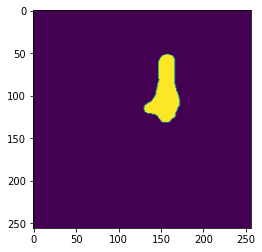

In [ ]:
# For testing
masks = getMasks([mask_index[4]], mask_data, category = label)
plt.imshow(masks[0])

In [ ]:
X = images.numpy()
y = mask_index.numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
x_test = torch.from_numpy(X_test)

In [ ]:
print(X_train.dtype)
print(y_train.dtype)

torch.uint8
torch.int64


In [ ]:
X_train.shape

torch.Size([6470, 256, 256])

In [ ]:
x_test.shape

torch.Size([2157, 256, 256])

In [ ]:
class GITract(Dataset):
    def __init__(self, tensors, transform=False):
        self.tensors = tensors
        self.transform = transform
        
    def __len__(self):
        return self.tensors[0].shape[0]

    def __getitem__(self, idx):
        return (self.tensors[0][idx], self.tensors[1][idx])

In [ ]:
train_set = GITract(tensors=(X_train, y_train))
test_set = GITract(tensors=(X_test, y_test))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

### Model Architecture

In [ ]:
def double_conv(in_c, out_c):
  conv = nn. Sequential(
    nn.Conv2d (in_c, out_c, kernel_size=3, padding = 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(out_c),
    nn.Conv2d(out_c, out_c, kernel_size=3, padding = 1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(out_c),
  )
  return conv

In [ ]:
class UNet(nn.Module):
  def __init__(self):
      super(UNet, self).__init__()
      
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.down_conv_1 = double_conv(1,64)
      self.down_conv_2 = double_conv(64,128)
      self.down_conv_3 = double_conv(128,256)
      self.down_conv_4 = double_conv(256,512)

      self.down_conv_5 = double_conv(512, 1024)

      self.up_trans_1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
      self.up_conv_1 = double_conv(1024,512)

      self.up_trans_2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
      self.up_conv_2 = double_conv(512,256)

      self.up_trans_3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
      self.up_conv_3 = double_conv(256,128)

      self.up_trans_4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
      self.up_conv_4 = double_conv(128,64)

      self.out = nn.Conv2d(64, 1, kernel_size=1)

      self.sig = nn.Sigmoid()


  def forward(self, image):
    
    x1 = self.down_conv_1(image)
    x11 = self.max_pool_2x2(x1)

    #print(x11.shape)

    x2 = self.down_conv_2(x11)
    x22 = self.max_pool_2x2(x2)

    #print(x22.shape)

    x3 = self.down_conv_3(x22)
    x33 = self.max_pool_2x2(x3)

    #print(x33.shape)

    x4 = self.down_conv_4(x33)
    x44 = self.max_pool_2x2(x4)

    x5 = self.down_conv_5(x44)

    #print(x5.shape)

    y1 = self.up_trans_1(x5)
    y11 = self.up_conv_1(torch.cat([y1, x4], 1))

    #print(y11.shape)

    y2 = self.up_trans_2(y11)
    y22 = self.up_conv_2(torch.cat([y2, x3], 1))

    #print(y22.shape)

    y3 = self.up_trans_3(y22)
    y33 = self.up_conv_3(torch.cat([y3, x2], 1))

    #print(y33.shape)

    y4 = self.up_trans_4(y33)
    y44 = self.up_conv_4(torch.cat([y4, x1], 1))

    #print(y44.shape)


    x = self.out(y44)

    x = self.sig(x)

    #print(x.shape)

    return x

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv_1 = nn.Conv2d (1, 16, kernel_size=7, padding = 1)
    self.conv_2 = nn.Conv2d (16, 16, kernel_size=7, padding = 1)

    self.conv_3 = nn.Conv2d (16, 32, kernel_size=5, padding = 1)
    self.conv_4 = nn.Conv2d (32, 32, kernel_size=5, padding = 1)
    self.conv_5 = nn.Conv2d (32, 32, kernel_size=5, padding = 1)
    self.conv_6 = nn.Conv2d (32, 32, kernel_size=5, padding = 1)

    self.conv_7 = nn.Conv2d (32, 64, kernel_size=5, padding = 1)
    self.conv_8 = nn.Conv2d (64, 64, kernel_size=5, padding = 1)
      
    self.fc = nn.Linear(64*11*11, 128*128)

    self.sig = nn.Sigmoid()


  def forward(self, image):
    
    x = F.relu(self.conv_1(image))
    x = F.relu(self.conv_2(x))

    x = self.max_pool_2x2(x)

    x = F.relu(self.conv_3(x))
    x = F.relu(self.conv_4(x))
    x = F.relu(self.conv_5(x))
    x = F.relu(self.conv_6(x))

    x = self.max_pool_2x2(x)

    x = F.relu(self.conv_7(x))
    x = F.relu(self.conv_8(x))
    
    x = self.max_pool_2x2(x)

    print(x.shape)

    x = x.view(-1, 64*11*11)

    x = self.fc(x)

    x = self.sig(x)


    return x

### Training

In [ ]:
model = UNet().to(device)
from torchsummary import summary

summary(model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
       BatchNorm2d-3         [-1, 64, 256, 256]             128
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
      BatchNorm2d-10        [-1, 128, 128, 128]             256
           Conv2d-11        [-1, 128, 128, 128]         147,584
             ReLU-12        [-1, 128, 128, 128]               0
      BatchNorm2d-13        [-1, 128, 128, 128]             256
        MaxPool2d-14          [-1, 128,

In [ ]:
checkpoint = torch.load(path + '/models/' + label + '/unet_stomach_25.pt')

In [ ]:
load = True

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

n_total_steps = len(train_loader)
epochloss = 0
running = 0
losslist = list()

ep = 0

if load:
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  ep = checkpoint['epoch']

epochs = 20

for epoch in range(epochs):

  print("Epoch {}/{} :".format(epoch, epochs))

  for i, (images, index) in enumerate(train_loader):
    images = images/255
    images = 1 - images
    images = torch.reshape(images, (images.shape[0], 1, images.shape[1], images.shape[2]))
  
    images = images.to(device)

    index_array = index.numpy()

    masks = getMasks(index_array, mask_data)
    masks = masks.astype('float32')
    masks = torch.from_numpy(masks)
    masks = masks/1

    masks = torch.reshape(masks, (masks.shape[0], 1, masks.shape[1], masks.shape[2]))
    masks = masks.to(device)

    outputs = model(images)

    loss = criterion(outputs, masks)

    epochloss += loss
    running += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % int(n_total_steps/5) == 0:
      print (f'     Step [{i+1}/{n_total_steps}], Loss: {running/int(n_total_steps/5)}')
      running = 0
  
  if (epoch+1)%5==0:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path + '/models/' + label + '/unet_stomach_' + str(epoch+1 + ep) + '.pt')
  
  losslist.append(epochloss/n_total_steps)
  print("Average Epoch Loss : ")
  print(epochloss/n_total_steps)
  epochloss=0

Epoch 0/20 :
     Step [40/203], Loss: 0.004051880445331335
     Step [80/203], Loss: 0.0036130398511886597
     Step [120/203], Loss: 0.0038983665872365236
     Step [160/203], Loss: 0.004357965663075447
     Step [200/203], Loss: 0.0043458784930408
Average Epoch Loss : 
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 1/20 :
     Step [40/203], Loss: 0.004240844398736954
     Step [80/203], Loss: 0.0038158942479640245
     Step [120/203], Loss: 0.0038230461068451405
     Step [160/203], Loss: 0.004121035803109407
     Step [200/203], Loss: 0.004185795318335295
Average Epoch Loss : 
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2/20 :
     Step [40/203], Loss: 0.0041325511410832405
     Step [80/203], Loss: 0.0036495074164122343
     Step [120/203], Loss: 0.003640654031187296
     Step [160/203], Loss: 0.0037671257741749287
     Step [200/203], Loss: 0.004241017159074545
Average Epoch Loss : 
tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3/

### Testing

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

checkpoint = torch.load(path + '/models/' + label + '/unet_stomach_34.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
ep = checkpoint['epoch']

In [ ]:
model.eval()

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_s

In [ ]:
a = np.array([np.zeros((1,256,256))])
b = np.array([np.zeros((1,256,256))])
c = np.array([np.zeros((1,256,256))])

for i, (images, index) in enumerate(test_loader):
  images = images/255
  images = 1 - images
  images = torch.reshape(images, (images.shape[0], 1, images.shape[1], images.shape[2]))
  a = a + images.numpy()
  images = images.to(device)

  index_array = index.numpy()

  masks = getMasks(index_array, mask_data)
  masks = torch.from_numpy(masks)
  masks = torch.reshape(masks, (masks.shape[0], 1, masks.shape[1], masks.shape[2]))
  b = b + masks.numpy()
  masks = masks.to(device)

  outputs = model(images)

  c = c + outputs.cpu().detach().numpy()
  break

In [ ]:
a.shape

(32, 1, 256, 256)

In [ ]:
b.shape

(32, 1, 256, 256)

In [ ]:
c.shape

(32, 1, 256, 256)

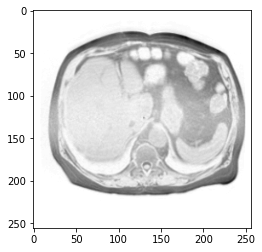

In [ ]:
plt.imshow(a[0].reshape((256,256)), cmap="gray")

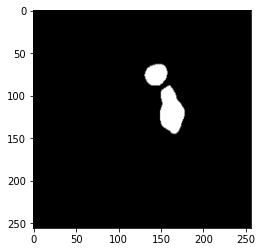

In [ ]:
plt.imshow(b[0].reshape((256,256)), cmap="gray")

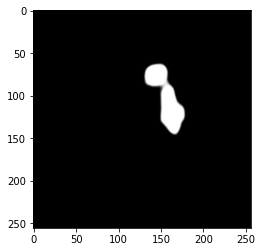

In [ ]:
plt.imshow(c[0].reshape((256,256)), cmap="gray") 